In [25]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from math import pi
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from xgboost import XGBRegressor

In [6]:
data = pd.read_csv('./historic_data.csv')
data['lag7'] = data['rides'].shift(7*24)
data['lag1'] = data['rides'].shift(1*24)
data.drop(['icon'], axis=1, inplace=True)

train_cut = int(len(data) * 0.8)
validate_cut = int(len(data) * 0.9)

train, validate, test = data.iloc[7*24:train_cut, :], data.iloc[train_cut:validate_cut, :], data.iloc[validate_cut:, :]

In [19]:
X_train, y_train = train.iloc[:, train.columns != 'rides'], train.iloc[:, train.columns == 'rides'].iloc[:, 0]
X_validate, y_validate = validate.iloc[:, validate.columns != 'rides'], validate.iloc[:, validate.columns == 'rides'].iloc[:, 0]
X_train.head()

,date,hour,month,day_of_week,sunrise,precip_prob,temperature,humidity,wind_speed,lag7,lag1
168,2013-06-08,0,6,7,0,0.93,60.44,0.94,5.84,152.0,51.0
169,2013-06-08,1,6,7,0,0.92,59.48,0.94,4.88,102.0,36.0
170,2013-06-08,2,6,7,0,0.90,58.81,0.94,5.17,67.0,16.0
171,2013-06-08,3,6,7,0,0.94,58.25,0.94,5.17,41.0,8.0
172,2013-06-08,4,6,7,0,0.83,57.63,0.94,6.30,16.0,4.0


<h1>Dummy Predictor</h1>

It is helpful to start with a heuristic predictor. The type of predictor that can be used without any statistical or machine learning knowledge. We can compare our ML work against this predictor to determine what type of improvement machine learning has added. 

In this heuristic I am simply making predictions by going back in time 1 year and finding the closest day of the week and resuing that number. That is, I am using the 3rd Wednesday in June 2015 to predict the 3rd Wednesday in June 2016. In the event that that information is not available, I simply take the last available data from the same hour of the day.

In [4]:
class YearAgoRegressor(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.X = X.loc[:, ['date', 'hour']]
        self.X['date'] = self.X['date'].map(lambda x: pd.to_datetime(x))
        self.X['rides'] = y
        return self
    
    def _meaning(self, x):
        prev_year = pd.to_datetime(x.date) - pd.DateOffset(years=1)
        day_delta = int(prev_year.strftime('%w')) + 1 - x.day_of_week
        prev_year = prev_year - pd.Timedelta(days=day_delta)
        if not self.X[(self.X.date == prev_year) & (self.X.hour == x.hour)].empty:
            return self.X[(self.X.date == prev_year) & (self.X.hour == x.hour)].iloc[0, :].rides
        return self.X[(self.X.hour == x.hour)].iloc[-1, :].rides
    
    def predict(self, X, y=None):
        return(X.apply(self._meaning, axis=1))

In [5]:
params = {}
pipeline = make_pipeline(
    YearAgoRegressor()
)
clf = GridSearchCV(pipeline, params, cv=TimeSeriesSplit(3), scoring='neg_mean_squared_error', n_jobs=-1, verbose=5)
clf.fit(train, train.rides)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None, steps=[('yearagoregressor', YearAgoRegressor())]),
       fit_params=None, iid='warn', n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=5)

In [6]:
clf.score(X_validate, y_validate)

-777558.4309392265

A MSE of ~777558 will serve as my baseline

<h1>SVM</h1>

In [9]:
class ColumnSelector(BaseEstimator, TransformerMixin):

    def __init__(self, columns=[]):
        self.columns = columns

    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        return X.loc[:, self.columns]

class CustomTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, func):
        self.func = func
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return self.func(X)

In [10]:
pipeline = Pipeline([
    ('union', FeatureUnion([
        ('cat', Pipeline([
            ('cat_selector', ColumnSelector(['sunrise'])),
            ('cat_ohe', OneHotEncoder(sparse=False))
        ])),
        ('year', Pipeline([
            ('year_selector', ColumnSelector(['date'])),
            ('year_extractor', CustomTransformer(lambda y: y.applymap(lambda x: float(pd.to_datetime(x).year - 2013)))),
            ('year_scaler', StandardScaler())
        ])),
        ('int', Pipeline([
            ('int_selector', ColumnSelector(['precip_prob', 'temperature', 'humidity', 'wind_speed', 'lag7', 'lag1'])),
            ('int_scaler', StandardScaler())
        ])),
        ('rad', Pipeline([
            ('rad_selector', ColumnSelector(['hour', 'day_of_week', 'month'])),
            ('rad_cos_sin', FeatureUnion([
                ('rad_cos', CustomTransformer(lambda y: y.apply(lambda x: np.round(np.cos(x * pi * 2/ x.nunique()), 5)))),
                ('rad_sin', CustomTransformer(lambda y: y.apply(lambda x: np.round(np.sin(x * pi * 2/ x.nunique()), 5))))
            ]))  
        ]))
    ])),
    ('svr', SVR())
])

In [11]:
params = {'svr__C': [500],
          'svr__gamma': [0.1]}
clf = GridSearchCV(pipeline, params, cv=TimeSeriesSplit(3), scoring='neg_mean_squared_error', n_jobs=-1, verbose=5)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished
C:\Users\Brian\Anaconda3\envs\citibike-dashboard\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\Brian\Anaconda3\envs\citibike-dashboard\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d ar

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('cat', Pipeline(memory=None,
     steps=[('cat_selector', ColumnSelector(columns=['sunrise'])), ('cat_ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
   ...
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'svr__C': [500], 'svr__gamma': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=5)

In [12]:
clf.score(X_validate, y_validate)

-271343.6329093849

<h1>Random Forest</h1>

In [20]:
pipeline = Pipeline([
    ('union', FeatureUnion([
        ('cat', Pipeline([
            ('cat_selector', ColumnSelector(['sunrise'])),
            ('cat_ohe', OneHotEncoder(sparse=False))
        ])),
        ('year', Pipeline([
            ('year_selector', ColumnSelector(['date'])),
            ('year_extractor', CustomTransformer(lambda y: y.applymap(lambda x: float(pd.to_datetime(x).year - 2013))))
        ])),
        ('int', Pipeline([
            ('int_selector', ColumnSelector(['precip_prob', 'temperature', 'humidity', 'wind_speed', 'lag7', 'lag1']))
        ])),
        ('rad', Pipeline([
            ('rad_selector', ColumnSelector(['hour', 'day_of_week', 'month'])),
            ('rad_cos_sin', FeatureUnion([
                ('rad_cos', CustomTransformer(lambda y: y.apply(lambda x: np.round(np.cos(x * pi * 2/ x.nunique()), 5)))),
                ('rad_sin', CustomTransformer(lambda y: y.apply(lambda x: np.round(np.sin(x * pi * 2/ x.nunique()), 5))))
            ]))  
        ]))
    ])),
    ('rfr', RandomForestRegressor())
])

In [21]:
params = {'rfr__n_estimators': [500],
          'rfr__max_depth': [20],
          'rfr__max_features': ['sqrt'],
         }
clf = GridSearchCV(pipeline, params, cv=TimeSeriesSplit(5), scoring='neg_mean_squared_error', n_jobs=-1, verbose=5)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.8s remaining:   19.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.7s finished
C:\Users\Brian\Anaconda3\envs\citibike-dashboard\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('cat', Pipeline(memory=None,
     steps=[('cat_selector', ColumnSelector(columns=['sunrise'])), ('cat_ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
   ...s='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'rfr__n_estimators': [500], 'rfr__max_depth': [20], 'rfr__max_features': ['sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=5)

In [22]:
clf.score(X_validate, y_validate)

-254013.47385280288

In [23]:
for i in sorted(zip(['sunrise', 'sunrise', 'date', 'precip', 'temp',
             'humidity', 'wind_speed', 'lag7', 'lag1', 'hour', 'hour', 'day_of_week', 'day_of_week', 'month', 'month']
             , clf.best_estimator_.named_steps['rfr'].feature_importances_), key=lambda x: x[1], reverse=True):
    print(i)

('lag7', 0.30893856577072853)
('lag1', 0.24446463869450927)
('sunrise', 0.06536291274141612)
('hour', 0.062456836844871154)
('sunrise', 0.058045963410199464)
('day_of_week', 0.05782371546325876)
('temp', 0.05395122559158719)
('precip', 0.03254889439178792)
('humidity', 0.02706546816265378)
('date', 0.019569183415959198)
('month', 0.01691642987612846)
('hour', 0.016632279994740717)
('wind_speed', 0.013133174028038867)
('month', 0.012645460354546854)
('day_of_week', 0.010445251259573917)


<h1>XG Boost</h1>

In [26]:
pipeline = Pipeline([
    ('union', FeatureUnion([
        ('cat', Pipeline([
            ('cat_selector', ColumnSelector(['sunrise'])),
            ('cat_ohe', OneHotEncoder(sparse=False))
        ])),
        ('year', Pipeline([
            ('year_selector', ColumnSelector(['date'])),
            ('year_extractor', CustomTransformer(lambda y: y.applymap(lambda x: float(pd.to_datetime(x).year))))
        ])),
        ('int', Pipeline([
            ('int_selector', ColumnSelector(['precip_prob', 'temperature', 'humidity', 'wind_speed', 'lag1', 'lag7']))
        ])),
        ('rad', Pipeline([
            ('rad_selector', ColumnSelector(['hour', 'day_of_week', 'month'])),
            ('rad_cos_sin', FeatureUnion([
                ('rad_cos', CustomTransformer(lambda y: y.apply(lambda x: np.round(np.cos(x * pi * 2/ x.nunique()), 5)))),
                ('rad_sin', CustomTransformer(lambda y: y.apply(lambda x: np.round(np.sin(x * pi * 2/ x.nunique()), 5))))
            ]))  
        ]))
    ])),
    ('xg', XGBRegressor())
])

In [27]:
params = {'xg__eta': [.005],
          'xg__max_depth': [5],
          'xg__n_estimators': [700],
          'xg__colsample_bytree': [0.5],
         }
clf = GridSearchCV(pipeline, params, cv=TimeSeriesSplit(5), scoring='neg_mean_squared_error', n_jobs=-1, verbose=5)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.8s remaining:   19.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.9s finished
C:\Users\Brian\Anaconda3\envs\citibike-dashboard\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('cat', Pipeline(memory=None,
     steps=[('cat_selector', ColumnSelector(columns=['sunrise'])), ('cat_ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
   ...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'xg__eta': [0.005], 'xg__max_depth': [5], 'xg__n_estimators': [700], 'xg__colsample_bytree': [0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=5)

In [28]:
clf.score(X_validate, y_validate)

-194076.2593373975

In [29]:
for i in sorted(zip(['sunrise', 'sunrise', 'date', 'precip', 'temp',
             'humidity', 'wind_speed', 'lag1', 'lag7', 'hour', 'hour', 'day_of_week', 'day_of_week', 'month', 'month']
             , clf.best_estimator_.named_steps['xg'].feature_importances_), key=lambda x: x[1], reverse=True):
    print(i)

('lag1', 0.14694831)
('temp', 0.13877323)
('lag7', 0.12902407)
('wind_speed', 0.093784906)
('humidity', 0.08474662)
('month', 0.058951966)
('day_of_week', 0.058342643)
('precip', 0.0551437)
('hour', 0.05037067)
('hour', 0.046714734)
('date', 0.03996141)
('day_of_week', 0.039504416)
('month', 0.03442673)
('sunrise', 0.014877628)
('sunrise', 0.008428963)


In [32]:
predictions = DataFrame(dict(date=X_validate.date, hour=X_validate.hour, pred=clf.predict(X_validate), val=y_validate))
predictions.head()

,date,hour,pred,val
31853,2017-01-27,4,116.986725,45
31854,2017-01-27,5,320.072327,282
31855,2017-01-27,6,1086.281372,973
31856,2017-01-27,7,2200.031982,2063
31857,2017-01-27,8,3257.684326,3812


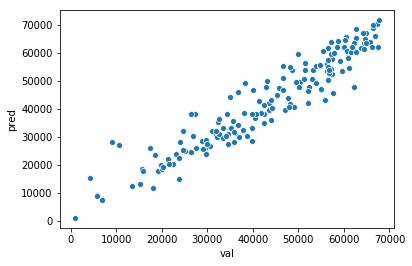

In [42]:
import seaborn as sns
%matplotlib inline

sns.scatterplot(x='val', y='pred', data=predictions \
    .groupby('date') \
    .agg('sum'))
    